# **FaceMask Detection** 

### **Using the Alexnet Architecture for this facemask detection system**
*URL of Paper: https://papers.nips.cc/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf*

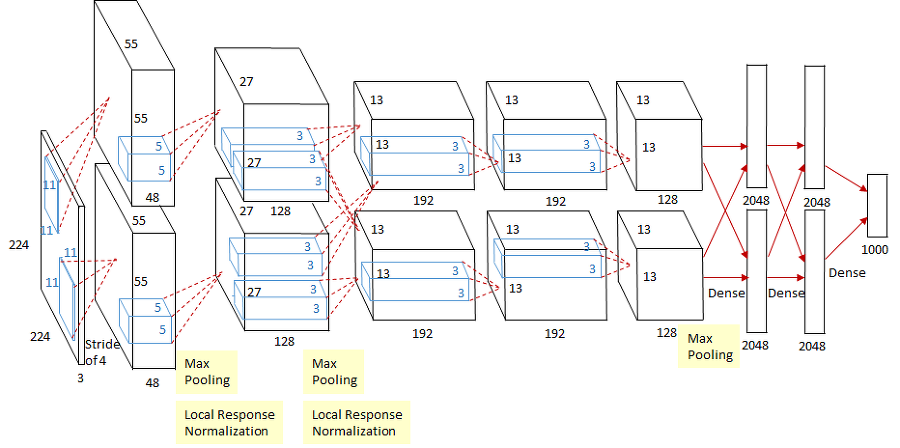

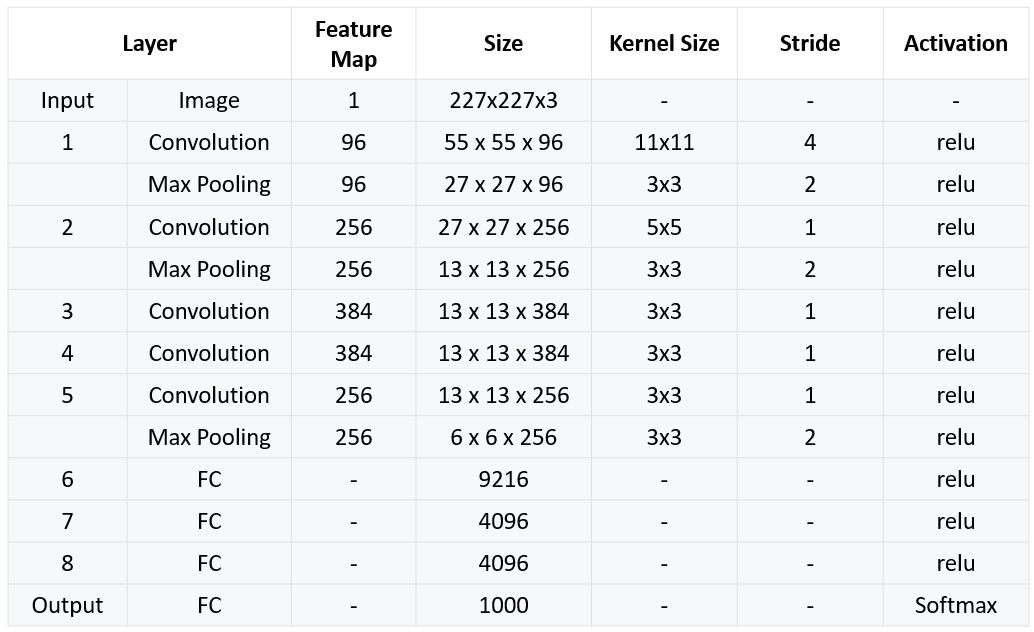

**Mounting with Google drive dataset**

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Importing Necessary Libraries**

In [13]:
import os
import cv2
import pandas as pd
import random
import pickle
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


np.random.seed(1000)
# ignore information messgaes from tensorflow, but we will receieve error messages
os.environ['TFF_CPP_MIN_LOG_LEVEL'] = '2'

%matplotlib inline

**Dataset Devided into Train, Valid and Test**

In [14]:
TRAIN_DATA_DIR = '/content/drive/MyDrive/Face_Mask /train'
VALID_DATA_DIR = '/content/drive/MyDrive/Face_Mask /valid'
TEST_DATA_DIR = '/content/drive/MyDrive/Face_Mask /test'

**Showing Two Categorical Data**

In [15]:
IMG_SIZE = 227
CATEGORIES = []

for i in os.listdir(TRAIN_DATA_DIR):
    CATEGORIES.append(i)
    
print(CATEGORIES)

['with_mask', 'without_mask']


**Plotting Categorical data for Train Dataset**

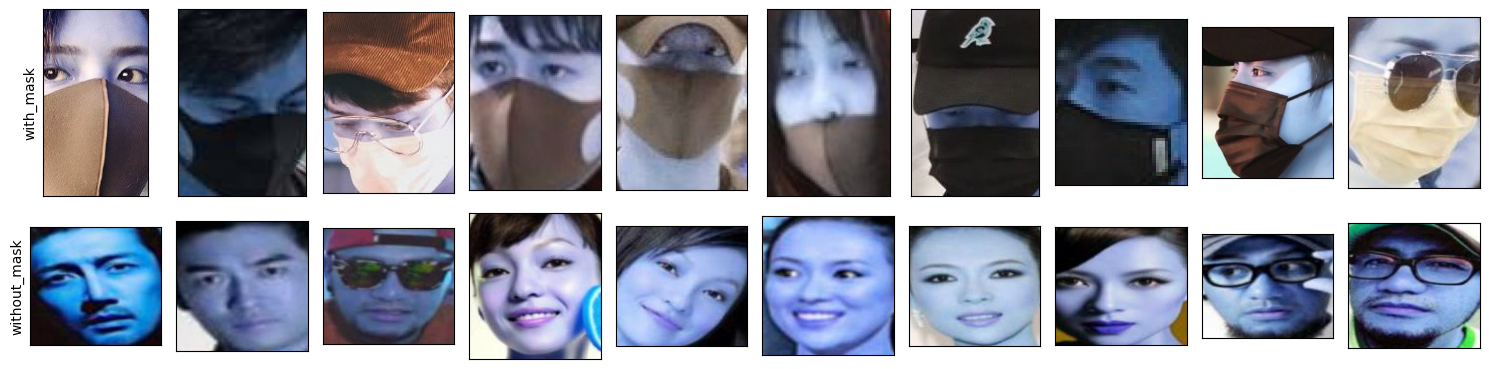

In [16]:
plt.figure(figsize=(15,4))
i=0
for c in CATEGORIES:  
    path = os.path.join(TRAIN_DATA_DIR,c)
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path,img))
        plt.subplot(2,10,i+1)
        plt.imshow(img_array)
        if i%10 == 0:
            plt.ylabel(c)
        plt.xticks([])
        plt.yticks([])
        i += 1
        if i%10 == 0:
            break

plt.tight_layout()        
plt.show() 

**Loading Train Data**

In [17]:
training_data = []

for c in CATEGORIES:
    path = os.path.join(TRAIN_DATA_DIR, c) # 'E:/DATASETS/classification/Face Mask Dataset/train/WithMask'
    class_num = CATEGORIES.index(c) # 0
    for img in tqdm(os.listdir(path)):
        try:
            img_array = cv2.imread(os.path.join(path, img))   # read the image
            img_resized = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  # resize the image
            training_data.append([img_resized, class_num]) # [ [img, 0], [], [], [], ...., []]
        except WException as e:
            pass
        
print(len(training_data))

100%|██████████| 1547/1547 [00:05<00:00, 282.11it/s]

3299


**Loading Valid Data**

In [18]:
valid_data = []

for c in CATEGORIES:
    path = os.path.join(VALID_DATA_DIR, c) 
    class_num = CATEGORIES.index(c) 
    for img in tqdm(os.listdir(path)):
        try:
            img_array = cv2.imread(os.path.join(path, img))   
            img_resized = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  
            valid_data.append([img_resized, class_num])
        except WException as e:
            pass
        
print(len(valid_data))

100%|██████████| 154/154 [00:00<00:00, 343.91it/s]

325


**Loading Test Data**

In [19]:
test_data = []

for c in CATEGORIES:
    path = os.path.join(TEST_DATA_DIR, c) 
    class_num = CATEGORIES.index(c) 
    for img in tqdm(os.listdir(path)):
        try:
            img_array = cv2.imread(os.path.join(path, img))   
            img_resized = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  
            test_data.append([img_resized, class_num])
        except WException as e:
            pass
        
print(len(test_data))

100%|██████████| 383/383 [00:01<00:00, 202.46it/s]

819


**Shuffling the data using random method**

In [20]:
random.shuffle(training_data)
random.shuffle(valid_data)
random.shuffle(test_data)

**Train Data Image Size and Labeling**

In [21]:
X_train = []
Y_train = []

for img, label in training_data:
    X_train.append(img)
    Y_train.append(label)
    
X_train = np.array(X_train).astype('float32').reshape(-1,227,227,3)
Y_train = np.array(Y_train)

print(f"X_train= {X_train.shape} Y_train= {Y_train.shape}")

X_train= (3299, 227, 227, 3) Y_train= (3299,)


**Valid Data Image Size and Labeling**

In [22]:
X_valid = []
Y_valid = []

for img, label in valid_data:
    X_valid.append(img)
    Y_valid.append(label)
    
X_valid = np.array(X_valid).astype('float32').reshape(-1,227,227,3)
Y_valid = np.array(Y_valid)

print(f"X_valid= {X_valid.shape} Y_valid= {Y_valid.shape}")

X_valid= (325, 227, 227, 3) Y_valid= (325,)


**Test Data Image Size and Labeling**

In [23]:
X_test = []
Y_test = []

for features,label in test_data:
    X_test.append(features)
    Y_test.append(label)

X_test = np.array(X_test).astype('float32').reshape(-1, IMG_SIZE, IMG_SIZE, 3)
Y_test = np.array(Y_test)

print(f"X_test= {X_test.shape} Y_test= {Y_test.shape}")

X_test= (819, 227, 227, 3) Y_test= (819,)


**Mean Figure of the Dataset**

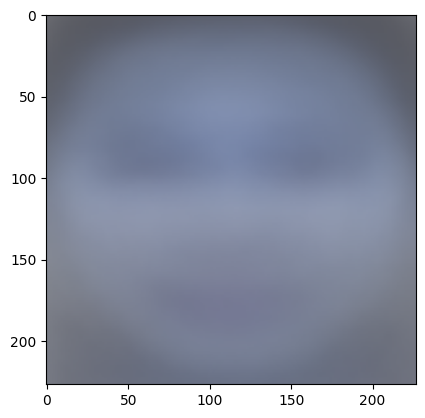

In [24]:
mean_img = np.mean(X_train, axis=0)
plt.imshow(mean_img.astype('uint8'))

**Normalization of Train, Valid and Test Data**

In [25]:
X_train_norm, X_valid_norm, X_test_norm = X_train-mean_img, X_valid-mean_img, X_test-mean_img

**Converting Data to a Scalar Data**

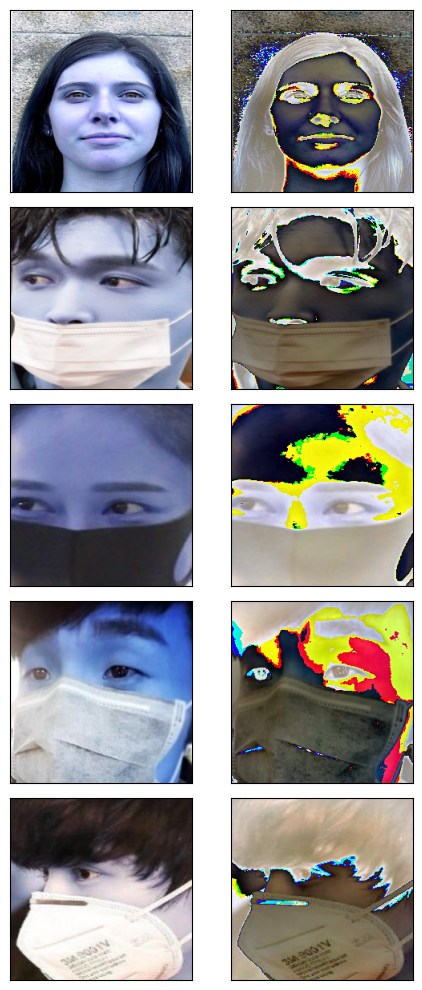

In [26]:
c = 0
plt.figure(figsize=(5,10))
for i in range(5):
    plt.subplot(5,2,c+1)
    plt.imshow(X_train[i].astype('uint8'))
    plt.xticks([])
    plt.yticks([])
    
    plt.subplot(5,2,c+2)
    plt.imshow(X_train_norm[i].astype('uint8'))
    plt.xticks([])
    plt.yticks([])

    c += 2
    
plt.tight_layout()
plt.show()

**Alexnet Architecture**

In [27]:
model = keras.Sequential([
    ## input layer
    keras.Input(shape=X_train.shape[1:]),
    
    
    layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), padding='valid'),
    layers.Activation('relu'),
    layers.MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'),
    layers.BatchNormalization(),
    
    layers.Conv2D(filters=256, kernel_size=(11,11), strides=(1,1), padding='valid'),
    layers.Activation('relu'),
    layers.MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'),
    layers.BatchNormalization(),
    
    layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid'),
    layers.Activation('relu'),
    layers.BatchNormalization(),
    
    layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid'),
    layers.Activation('relu'),
    layers.BatchNormalization(),
    
    layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='valid'),
    layers.Activation('relu'),
    layers.MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'),
    layers.BatchNormalization(),
    
    layers.Flatten(),
    
    layers.Dense(units=4096),
    layers.Activation('relu'),
    layers.Dropout(0.5),
    layers.BatchNormalization(),
    
    layers.Dense(units=4096),
    layers.Activation('relu'),
    layers.Dropout(0.5),
    layers.BatchNormalization(),

    layers.Dense(1),
    layers.Activation('sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 55, 55, 96)        34944     
                                                                 
 activation (Activation)     (None, 55, 55, 96)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 27, 27, 96)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 27, 27, 96)       384       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 17, 17, 256)       2973952   
                                                                 
 activation_1 (Activation)   (None, 17, 17, 256)       0

**Compiling Optimizer, Loss and Accuracy Metrics**

In [28]:
model.compile(
    optimizer='adam', 
    loss='binary_crossentropy', 
    metrics=['accuracy']
)

**Model Fitting**

In [29]:
h = model.fit(x=X_train_norm, y=Y_train, epochs=10, validation_data=(X_valid_norm, Y_valid), batch_size=32)

Epoch 1/10
104/104 [==============================] - 378s 4s/step - loss: 0.5675 - accuracy: 0.8457 - val_loss: 0.4179 - val_accuracy: 0.9385
Epoch 2/10
104/104 [==============================] - 375s 4s/step - loss: 0.2975 - accuracy: 0.8939 - val_loss: 0.2396 - val_accuracy: 0.9169
Epoch 3/10
104/104 [==============================] - 374s 4s/step - loss: 0.3350 - accuracy: 0.8791 - val_loss: 0.1404 - val_accuracy: 0.9600
Epoch 4/10
104/104 [==============================] - 374s 4s/step - loss: 0.2300 - accuracy: 0.9188 - val_loss: 0.0540 - val_accuracy: 0.9877
Epoch 5/10
104/104 [==============================] - 373s 4s/step - loss: 0.2056 - accuracy: 0.9236 - val_loss: 0.1268 - val_accuracy: 0.9600
Epoch 6/10
104/104 [==============================] - 374s 4s/step - loss: 0.2508 - accuracy: 0.9106 - val_loss: 0.1220 - val_accuracy: 0.9569
Epoch 7/10
104/104 [==============================] - 377s 4s/step - loss: 0.2180 - accuracy: 0.9236 - val_loss: 0.1231 - val_accuracy: 0.9538

**Plotting Training and Validation Accuracy and Loss Graph**

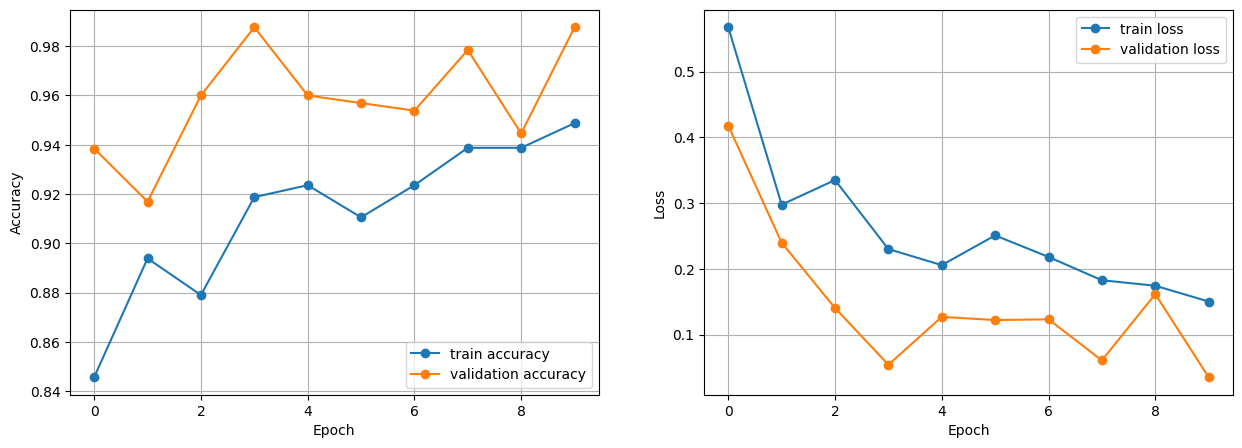

In [30]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(h.history['accuracy'], 'o-', label='train accuracy')
plt.plot(h.history['val_accuracy'], 'o-', label = 'validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend(loc='lower right')

plt.subplot(1,2,2)
plt.plot(h.history['loss'], 'o-', label='train loss')
plt.plot(h.history['val_loss'], 'o-', label='validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend(loc='upper right')

plt.show()

**Showing Test Accuracy and Test Loss**

In [31]:
test_loss, test_acc = model.evaluate(X_test_norm, Y_test)
print('\nTest Accuracy:', test_acc)
print('\nTest Loss:', test_loss)

26/26 [==============================] - 22s 835ms/step - loss: 0.3241 - accuracy: 0.8706

Test Accuracy: 0.870573878288269

Test Loss: 0.32413265109062195
